# K-Means


In [31]:
import pandas as pd

# Load dataset
df = pd.read_excel('Online_Retail.xlsx')
df.head()


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [32]:
df = df[df['Customer ID'].notnull()]
df = df[(df['Quantity'] > 0) & (df['Price'] > 0)]



In [33]:



df = df[df['Customer ID'].notnull()]

# 2. Remove rows with Quantity <= 0 or Price <= 0
df = df[(df['Quantity'] > 0) & (df['Price'] > 0)]

# 3. Remove canceled invoices (those starting with 'C')
df = df[~df['Invoice'].astype(str).str.startswith('C')]

# Check how many rows and columns remain
df.shape


(407664, 8)

In [34]:
# converting
df['StockCode'] = df['StockCode'].astype(str)

# not null
df = df[df['StockCode'].notna()]

#  removing characters in it
df = df[df['StockCode'].str.isnumeric()]


In [35]:
df['StockCode']

0         85048
3         22041
4         21232
5         22064
6         21871
          ...  
525456    22271
525457    22750
525458    22751
525459    20970
525460    21931
Name: StockCode, Length: 350902, dtype: object

In [36]:
# Step 3: Create RFM features

import datetime as dt

# Create snapshot date (1 day after the last invoice date)
snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

# Group by Customer ID
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'Invoice': 'nunique',                                     # Frequency
    'Price': lambda x: (x * df.loc[x.index, 'Quantity']).sum()  # Monetary
})

# Rename columns
rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'Invoice': 'Frequency',
    'Price': 'Monetary'
}, inplace=True)

# Display result
rfm.head()


,Recency,Frequency,Monetary
Customer ID,,,
12346.0,165,2,144.02
12347.0,3,2,966.87
12348.0,74,1,221.16
12349.0,43,2,1946.64
12351.0,11,1,300.93


In [37]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the RFM data
rfm_scaled = scaler.fit_transform(rfm)

# rfm_scaled is now a NumPy array; convert back to DataFrame for readability
import pandas as pd
rfm_scaled = pd.DataFrame(rfm_scaled, index=rfm.index, columns=rfm.columns)

rfm_scaled.head()


,Recency,Frequency,Monetary
Customer ID,,,
12346.0,0.773953,-0.306190,-0.210398
12347.0,-0.907136,-0.306190,-0.101123
12348.0,-0.170362,-0.435036,-0.200154
12349.0,-0.492052,-0.306190,0.028991
12351.0,-0.824119,-0.435036,-0.189560


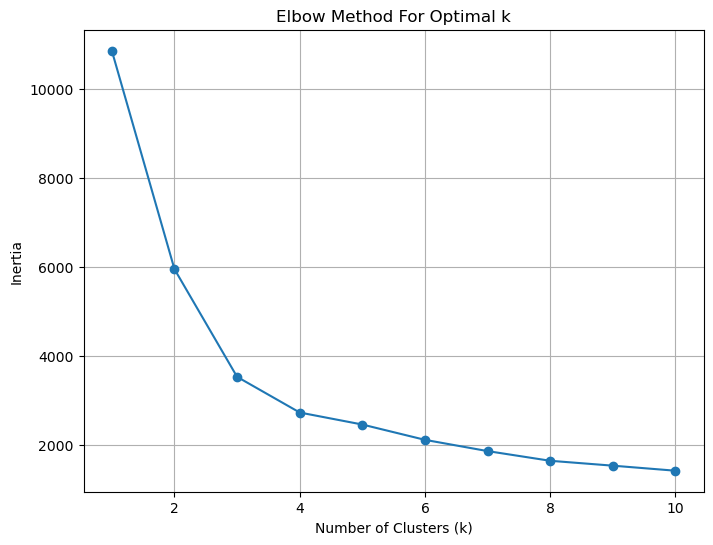

In [47]:
inertia = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_non_outliers_scaled)  # or rfm_outliers_scaled
    inertia.append(kmeans.inertia_)

# Plot the elbow
plt.figure(figsize=(8, 6))
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()


In [48]:
from sklearn.metrics import silhouette_score

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(rfm_non_outliers_scaled)
    score = silhouette_score(rfm_non_outliers_scaled, labels)
    print(f"k = {k} --> Silhouette Score = {score:.4f}")


k = 2 --> Silhouette Score = 0.4364
k = 3 --> Silhouette Score = 0.4556
k = 4 --> Silhouette Score = 0.4109
k = 5 --> Silhouette Score = 0.4035
k = 6 --> Silhouette Score = 0.3916
k = 7 --> Silhouette Score = 0.3660
k = 8 --> Silhouette Score = 0.3510
k = 9 --> Silhouette Score = 0.3090
k = 10 --> Silhouette Score = 0.2996


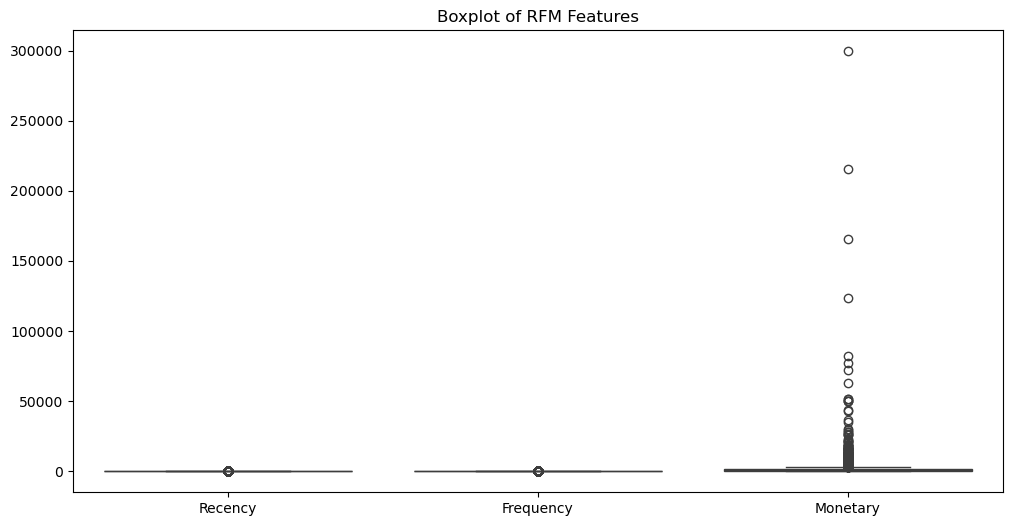

In [41]:
import seaborn as sns

# Boxplot for Recency, Frequency, and Monetary
plt.figure(figsize=(12, 6))
sns.boxplot(data=rfm[['Recency', 'Frequency', 'Monetary']])
plt.title('Boxplot of RFM Features')
plt.show()


In [42]:
# Calculate IQR (Interquartile Range)
Q1 = rfm.quantile(0.25)
Q3 = rfm.quantile(0.75)
IQR = Q3 - Q1

# Define the outlier condition
outlier_condition = (rfm < (Q1 - 1.5 * IQR)) | (rfm > (Q3 + 1.5 * IQR))

# Separate the outliers and non-outliers
rfm_outliers = rfm[outlier_condition.any(axis=1)]  # Rows with outliers
rfm_non_outliers = rfm[~outlier_condition.any(axis=1)]  # Rows without outliers

# Check the shapes
print(f"Outliers shape: {rfm_outliers.shape}")
print(f"Non-Outliers shape: {rfm_non_outliers.shape}")


Outliers shape: (628, 3)
Non-Outliers shape: (3620, 3)


In [43]:
# Scale the non-outliers data
rfm_non_outliers_scaled = scaler.fit_transform(rfm_non_outliers)


In [49]:
# Apply K-Means (assume k = 4 based on elbow)
kmeans_non_outliers = KMeans(n_clusters=4, random_state=42)
labels_non_outliers = kmeans_non_outliers.fit_predict(rfm_non_outliers_scaled)

# Use labels 0, 1, 2, 3
rfm_non_outliers['Cluster'] = labels_non_outliers


C:\Users\manoj gowda\AppData\Local\Temp\ipykernel_464\2768436843.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_non_outliers['Cluster'] = labels_non_outliers


In [45]:
# Scale the outliers data
rfm_outliers_scaled = scaler.fit_transform(rfm_outliers)


In [50]:
# Apply K-Means for outliers
kmeans_outliers = KMeans(n_clusters=4, random_state=42)
labels_outliers = kmeans_outliers.fit_predict(rfm_outliers_scaled)

# Convert to negative labels: -1, -2, -3, -4
rfm_outliers['Cluster'] = -(labels_outliers + 1)


C:\Users\manoj gowda\AppData\Local\Temp\ipykernel_464\2386257517.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_outliers['Cluster'] = -(labels_outliers + 1)


In [51]:
# Combine non-outliers and outliers into one dataframe
rfm_combined = pd.concat([rfm_non_outliers, rfm_outliers])

# Optional: Reset index
rfm_combined = rfm_combined.reset_index()

rfm_combined.head()


,Customer ID,Recency,Frequency,Monetary,Cluster
0,12346.0,165,2,144.02,3
1,12347.0,3,2,966.87,1
2,12348.0,74,1,221.16,1
3,12349.0,43,2,1946.64,0
4,12351.0,11,1,300.93,1


In [52]:
# Group by cluster and get mean RFM values
cluster_profile = rfm_combined.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean().round(1)

# Count of customers in each cluster
cluster_profile['Num_Customers'] = rfm_combined['Cluster'].value_counts()

# Sort by cluster label
cluster_profile = cluster_profile.sort_index()

cluster_profile


,Recency,Frequency,Monetary,Num_Customers
Cluster,,,,
-4,6.5,106.5,201014.5,4
-3,345.6,1.4,748.7,176
-2,11.1,60.7,31340.8,31
-1,24.4,13.0,6118.0,417
0,47.4,4.0,1196.6,885
1,51.6,1.7,379.1,1467
2,34.0,7.3,2128.8,461
3,222.4,1.5,355.5,807


In [ ]:
#  -4  big players   -3  interest them     -2  reward them     -1   loyal    0   good     1  cold     2   keep them int   3  rarely

In [53]:
# Define the mapping
segment_map = {
    -4: "Big Players",
    -3: "Interest Them",
    -2: "Reward Them",
    -1: "Loyal",
     0: "Good",
     1: "Cold",
     2: "Keep Them Interested",
     3: "Rarely"
}

# Add a new column for segment name
rfm_combined['Segment'] = rfm_combined['Cluster'].map(segment_map)

# View updated DataFrame
rfm_combined[['Cluster', 'Segment']].drop_duplicates().sort_values(by='Cluster')


,Cluster,Segment
3828,-4,Big Players
3629,-3,Interest Them
3633,-2,Reward Them
3620,-1,Loyal
3,0,Good
1,1,Cold
10,2,Keep Them Interested
0,3,Rarely


# Visualize

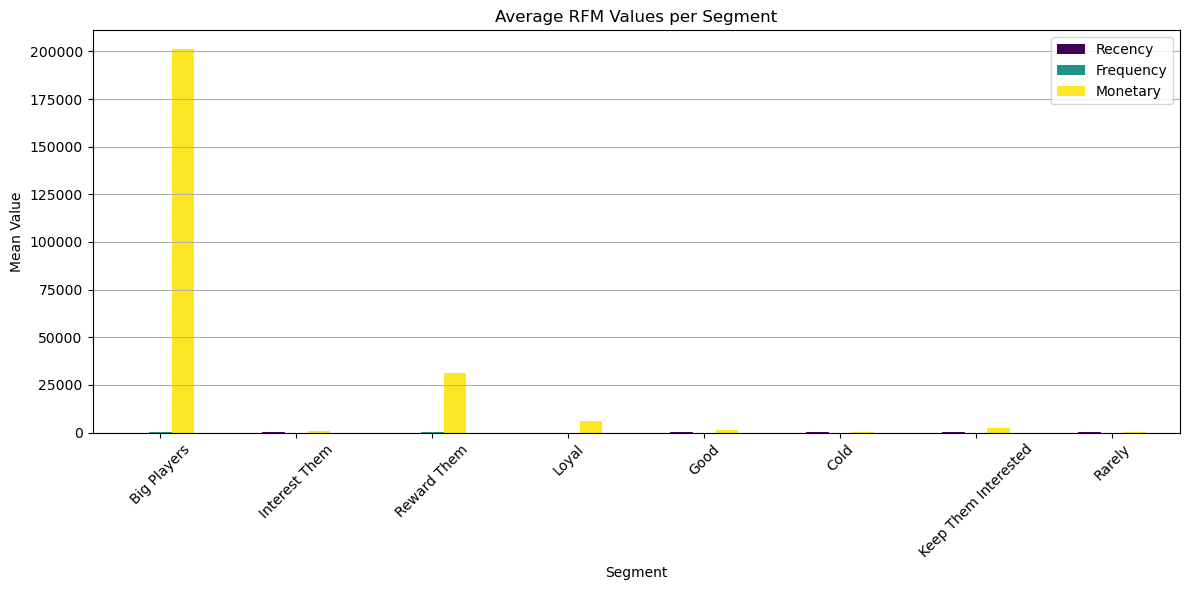

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group by segment name
rfm_segmented = rfm_combined.groupby('Segment')[['Recency', 'Frequency', 'Monetary']].mean().round(1)

# Sort for consistent display
rfm_segmented = rfm_segmented.loc[segment_map.values()]

# Plot
rfm_segmented.plot(kind='bar', figsize=(12, 6), colormap='viridis')
plt.title("Average RFM Values per Segment")
plt.ylabel("Mean Value")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


C:\Users\manoj gowda\AppData\Local\Temp\ipykernel_464\4029473504.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=segment_counts.index, y=segment_counts.values, palette="viridis")


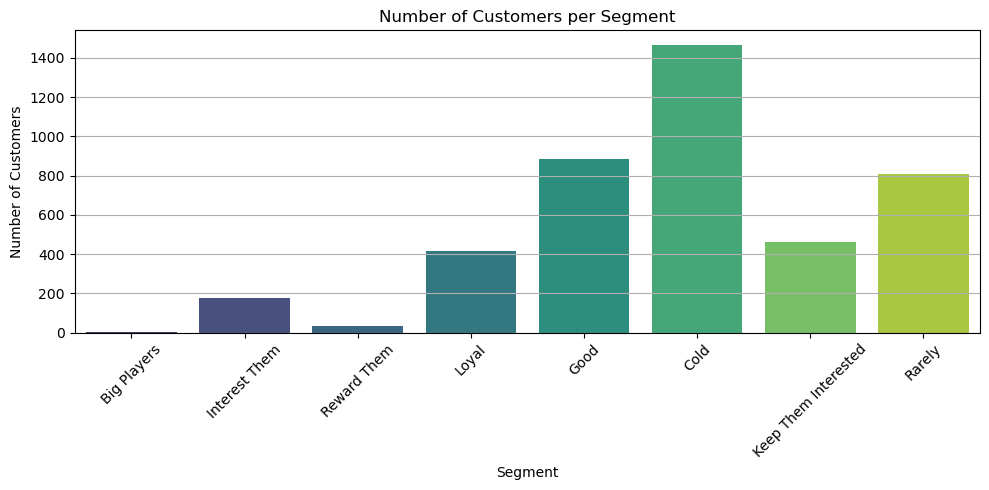

In [55]:
# Count customers per segment
segment_counts = rfm_combined['Segment'].value_counts().loc[segment_map.values()]

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x=segment_counts.index, y=segment_counts.values, palette="viridis")
plt.title("Number of Customers per Segment")
plt.ylabel("Number of Customers")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


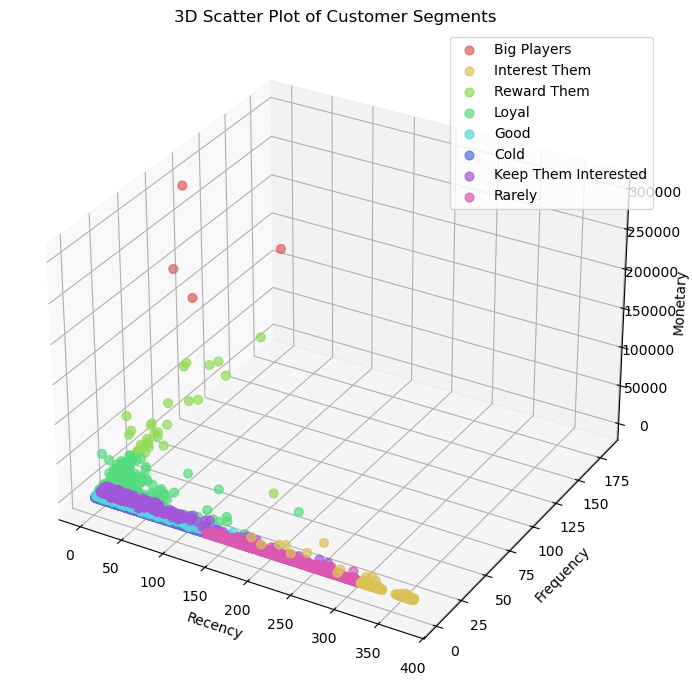

In [56]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Assign colors for each segment
colors = sns.color_palette("hls", len(rfm_combined['Segment'].unique()))
segment_color_map = dict(zip(segment_map.values(), colors))

# Plot points
for segment, color in segment_color_map.items():
    subset = rfm_combined[rfm_combined['Segment'] == segment]
    ax.scatter(subset['Recency'], subset['Frequency'], subset['Monetary'], 
               label=segment, color=color, s=40, alpha=0.7)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title("3D Scatter Plot of Customer Segments")
ax.legend()
plt.tight_layout()
plt.show()


In [57]:
rfm_combined.to_csv('rfm_combined.csv', index=False)
